# Proximal Policy Optimization (PPO) for LLM Alignment (From Scratch)


- This code notebook implements Reinforcement Learning from Human Feedback (RLHF) using Proximal Policy Optimization (PPO) from scratch
- RLHF with PPO is the classical approach used to align LLMs like ChatGPT and consists of two main steps:
  1. **Reward Model Training**: Train a model to predict human preferences
  2. **Policy Optimization with PPO**: Use the reward model to optimize the LLM's responses


In [44]:
from importlib.metadata import version

pkgs = [
    "tiktoken",    # Tokenizer
    "torch",       # Deep learning library
]
for p in pkgs:
    print(f"{p} version: {version(p)}")


tiktoken version: 0.9.0
torch version: 2.9.0


&nbsp;
# 1) A Brief Introduction to RLHF and PPO


## 1.1) The RLHF Pipeline

- RLHF (Reinforcement Learning from Human Feedback) is a technique to align LLMs with human preferences
- The classical RLHF pipeline consists of three stages:
  1. **Supervised Fine-Tuning (SFT)**: Train the base model on high-quality instruction-response pairs
  2. **Reward Modeling**: Train a reward model on human preference data (chosen vs rejected responses)
  3. **Policy Optimization**: Use RL (typically PPO) to optimize the policy model using the reward model

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/dpo/4.webp" width=600px>

- In this notebook, we assume SFT has already been done (we load the finetuned model from chapter 7)
- We will implement steps 2 and 3: Reward Modeling and PPO


## 1.2) Reward Modeling

- The reward model learns to predict which response a human would prefer
- Given a prompt $x$ and two responses $y_w$ (chosen/winning) and $y_l$ (rejected/losing), the reward model learns to assign higher scores to preferred responses
- The reward model is trained using the Bradley-Terry model, which models pairwise preferences:

$$P(y_w \succ y_l | x) = \sigma(r_\theta(x, y_w) - r_\theta(x, y_l))$$

- Where $r_\theta$ is the reward model and $\sigma$ is the sigmoid function
- The loss function is:

$$\mathcal{L}_{RM} = -\mathbb{E}_{(x, y_w, y_l) \sim D} \left[ \log \sigma(r_\theta(x, y_w) - r_\theta(x, y_l)) \right]$$


## 1.3) Proximal Policy Optimization (PPO)

- PPO is a policy gradient algorithm that optimizes the policy while preventing too large updates
- The key idea is to clip the policy ratio to ensure stable training
- The PPO objective for LLM alignment combines several components:

**Policy Loss (with clipping):**
$$\mathcal{L}_{PPO} = -\mathbb{E} \left[ \min\left( \frac{\pi_\theta(a|s)}{\pi_{\theta_{old}}(a|s)} \hat{A}, \text{clip}\left(\frac{\pi_\theta(a|s)}{\pi_{\theta_{old}}(a|s)}, 1-\epsilon, 1+\epsilon\right) \hat{A} \right) \right]$$

**KL Penalty:**
- To prevent the policy from deviating too far from the reference model:
$$\mathcal{L}_{KL} = \beta \cdot D_{KL}(\pi_\theta || \pi_{ref})$$

**Value Function Loss:**
- For advantage estimation:
$$\mathcal{L}_{V} = (V_\phi(s) - R)^2$$

**Total Loss:**
$$\mathcal{L} = \mathcal{L}_{PPO} + c_1 \mathcal{L}_{V} + c_2 \mathcal{L}_{KL}$$


## 1.4) PPO vs DPO

- **DPO** (Direct Preference Optimization) simplifies RLHF by eliminating the need for a separate reward model
- **PPO** is more flexible and was used in the original InstructGPT/ChatGPT training
- Trade-offs:
  - DPO: Simpler, more stable, but less flexible
  - PPO: More complex, requires careful tuning, but can work with any reward signal

In this notebook, we implement the full RLHF pipeline with PPO to understand the classical approach.


&nbsp;
# 2) Preparing the Preference Dataset


- We use the same preference dataset as in the DPO notebook
- The dataset contains instruction prompts with "chosen" (preferred) and "rejected" (dispreferred) responses
- We'll use this data for both reward model training and PPO training


## 2.1) Loading the Preference Dataset


In [ ]:
import json
import os


file_path = "instruction-data-with-preference.json"


with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

data = json.loads(text_data)


print("Number of entries:", len(data))

Number of entries: 1100


- Let's look at some example entries:


In [46]:
import pprint

pprint.pp(data[50])


{'instruction': 'Identify the correct spelling of the following word.',
 'input': 'Ocassion',
 'output': "The correct spelling is 'Occasion.'",
 'rejected': "The correct spelling is obviously 'Occasion.'",
 'chosen': "The correct spelling is 'Occasion.'"}


- Below is a utility function that formats the model input using the Alpaca prompt style:


In [47]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text


In [48]:
model_input = format_input(data[50])
print(model_input)


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion


## 2.2) Creating Training, Validation, and Test Splits


In [49]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))


Training set length: 935
Validation set length: 55
Test set length: 110


## 2.3) Creating Dataset Classes for Reward Model and PPO

- We need two different dataset classes:
  1. `PreferenceDataset`: For reward model training (pairs of chosen/rejected responses)
  2. `PromptDataset`: For PPO training (just prompts, model generates responses)


In [50]:
import torch
from torch.utils.data import Dataset


class PreferenceDataset(Dataset):
    """Dataset for reward model training with chosen/rejected pairs."""
    
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            prompt = format_input(entry)
            rejected_response = entry["rejected"]
            chosen_response = entry["chosen"]

            prompt_tokens = tokenizer.encode(prompt)
            chosen_full_text = f"{prompt}\n\n### Response:\n{chosen_response}"
            rejected_full_text = f"{prompt}\n\n### Response:\n{rejected_response}"
            chosen_full_tokens = tokenizer.encode(chosen_full_text)
            rejected_full_tokens = tokenizer.encode(rejected_full_text)

            self.encoded_texts.append({
                "prompt": prompt_tokens,
                "chosen": chosen_full_tokens,
                "rejected": rejected_full_tokens,
            })

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)


In [ ]:
class PromptDataset(Dataset):
    """Dataset for PPO training - only prompts, model generates responses."""
    
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer
        
        # Pre-tokenize prompts
        self.encoded_prompts = []
        for entry in data:
            prompt = format_input(entry)
            prompt_tokens = tokenizer.encode(prompt)
            self.encoded_prompts.append({
                "prompt": prompt_tokens,
                "prompt_text": prompt,
                "chosen": entry["chosen"],
                "rejected": entry["rejected"]
            })

    def __getitem__(self, index):
        return self.encoded_prompts[index]

    def __len__(self):
        return len(self.data)


## 2.4) Collate Functions and Data Loaders


In [52]:
def preference_collate_fn(
    batch,
    pad_token_id=50256,
    allowed_max_length=None,
    device="cpu"
):
    """Collate function for reward model training."""
    batch_data = {
        "chosen": [],
        "rejected": [],
    }

    # Determine the longest sequence for padding
    max_length_common = 0
    if batch:
        for key in ["chosen", "rejected"]:
            current_max = max(len(item[key]) + 1 for item in batch)
            max_length_common = max(max_length_common, current_max)

    # Process each item
    for item in batch:
        for key in ["chosen", "rejected"]:
            sequence = item[key]
            padded = sequence + [pad_token_id] * (max_length_common - len(sequence))
            batch_data[key].append(torch.tensor(padded))

    # Stack and optionally truncate
    for key in ["chosen", "rejected"]:
        tensor_stack = torch.stack(batch_data[key])
        if allowed_max_length is not None:
            tensor_stack = tensor_stack[:, :allowed_max_length]
        batch_data[key] = tensor_stack.to(device)

    return batch_data


In [ ]:
def prompt_collate_fn(
    batch,
    pad_token_id=50256,
    allowed_max_length=None,
    device="cpu"
):
    """Collate function for PPO training - pads prompts from the right.
    
    Note: We pad from the RIGHT and track original lengths. This avoids
    the issue where left-padding with EOS tokens confuses the model.
    """
    batch_data = {
        "prompt": [],
        "prompt_text": [],
        "prompt_lengths": [],  # Track original prompt lengths
        "chosen": [],
        "rejected": [],
    }

    # Determine max prompt length
    max_prompt_length = max(len(item["prompt"]) for item in batch)

    for item in batch:
        prompt = item["prompt"]
        prompt_length = len(prompt)
        padding_length = max_prompt_length - prompt_length
        # Right-pad with pad_token_id
        padded_prompt = prompt + [pad_token_id] * padding_length
        batch_data["prompt"].append(torch.tensor(padded_prompt))
        batch_data["prompt_lengths"].append(prompt_length)
        batch_data["prompt_text"].append(item["prompt_text"])
        batch_data["chosen"].append(item["chosen"])
        batch_data["rejected"].append(item["rejected"])

    # Stack prompts
    tensor_stack = torch.stack(batch_data["prompt"])
    if allowed_max_length is not None:
        tensor_stack = tensor_stack[:, :allowed_max_length]  # Keep leftmost tokens
    batch_data["prompt"] = tensor_stack.to(device)
    batch_data["prompt_lengths"] = torch.tensor(batch_data["prompt_lengths"]).to(device)

    return batch_data


- Set up device and create customized collate functions:


In [ ]:
from functools import partial

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", device)

customized_preference_collate_fn = partial(
    preference_collate_fn,
    device=device,
    allowed_max_length=512  # Shorter for reward model
)

customized_prompt_collate_fn = partial(
    prompt_collate_fn,
    device=device,
    allowed_max_length=512
)


Device: cuda


- Create data loaders for reward model training:


In [55]:
import tiktoken
from torch.utils.data import DataLoader

tokenizer = tiktoken.get_encoding("gpt2")

num_workers = 0
batch_size = 4  # Smaller batch size for PPO (memory intensive)

torch.manual_seed(123)

# Reward model training data loaders
rm_train_dataset = PreferenceDataset(train_data, tokenizer)
rm_train_loader = DataLoader(
    rm_train_dataset,
    batch_size=batch_size,
    collate_fn=customized_preference_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

rm_val_dataset = PreferenceDataset(val_data, tokenizer)
rm_val_loader = DataLoader(
    rm_val_dataset,
    batch_size=batch_size,
    collate_fn=customized_preference_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

print(f"Reward model train batches: {len(rm_train_loader)}")
print(f"Reward model val batches: {len(rm_val_loader)}")


Reward model train batches: 233
Reward model val batches: 14


- Create data loaders for PPO training:


In [56]:
# PPO training data loaders
ppo_train_dataset = PromptDataset(train_data, tokenizer)
ppo_train_loader = DataLoader(
    ppo_train_dataset,
    batch_size=batch_size,
    collate_fn=customized_prompt_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

ppo_val_dataset = PromptDataset(val_data, tokenizer)
ppo_val_loader = DataLoader(
    ppo_val_dataset,
    batch_size=batch_size,
    collate_fn=customized_prompt_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

print(f"PPO train batches: {len(ppo_train_loader)}")
print(f"PPO val batches: {len(ppo_val_loader)}")


PPO train batches: 233
PPO val batches: 14


&nbsp;
# 3) Loading the Finetuned LLM


- We load the instruction-finetuned model from chapter 7
- This model will serve as:
  1. The base for the reward model (we'll add a value head)
  2. The initial policy model for PPO
  3. The frozen reference model for KL penalty


In [57]:
from pathlib import Path
import shutil


finetuned_model_path = Path("gpt2-medium355M-sft.pth")
if not finetuned_model_path.exists():
    # Try finding the model checkpoint locally
    relative_path = Path("..") / "01_main-chapter-code" / finetuned_model_path
    if relative_path.exists():
        shutil.copy(relative_path, ".")
    else:
        print(
            f"Could not find '{finetuned_model_path}'.\n"
            "Run the `ch07.ipynb` notebook to finetune and save the finetuned model."
        )


In [58]:
from previous_chapters import GPTModel

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])
print("Model config:", BASE_CONFIG)


Model config: {'vocab_size': 50257, 'context_length': 1024, 'drop_rate': 0.0, 'qkv_bias': True, 'emb_dim': 1024, 'n_layers': 24, 'n_heads': 16}


- Load and verify the model works:


In [59]:
model = GPTModel(BASE_CONFIG)
model.load_state_dict(
    torch.load(
        "gpt2-medium355M-sft.pth",
        map_location=torch.device("cpu"),
        weights_only=True
    )
)
model.eval()
print(f"Model loaded with {sum(p.numel() for p in model.parameters()):,} parameters")


Model loaded with 406,286,336 parameters


- Test the model with a sample prompt:


In [60]:
from previous_chapters import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)

prompt = """Below is an instruction that describes a task. Write a response
that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'
"""

torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids(prompt, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256
)

response = token_ids_to_text(token_ids, tokenizer)
print(response)


Below is an instruction that describes a task. Write a response
that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Response:
The meal is cooked every day by the chef.


In [61]:
def extract_response(response_text, input_text):
    return response_text[len(input_text):].replace("### Response:", "").strip()

response = extract_response(response, prompt)
print("Model response:", response)


Model response: The meal is cooked every day by the chef.


&nbsp;
# 4) Step 1: Reward Model Training


- The reward model is a crucial component of RLHF
- It learns to predict which responses humans would prefer
- We'll build it by taking our GPT model and adding a linear "value head" that outputs a scalar reward


## 4.1) Reward Model Architecture


In [62]:
import torch.nn as nn


class RewardModel(nn.Module):
    """
    Reward model that takes a GPT model as backbone and adds a value head.
    
    The model processes sequences and outputs scalar rewards.
    For each sequence, we take the last token's hidden state and project it to a scalar.
    """
    
    def __init__(self, cfg):
        super().__init__()
        
        # Use GPT model as backbone but remove the language model head
        self.backbone = GPTModel(cfg)
        
        # Replace the output head with a value head
        # The backbone's final_norm output has shape (batch, seq_len, emb_dim)
        # We project the last token's embedding to a scalar reward
        self.value_head = nn.Linear(cfg["emb_dim"], 1, bias=False)
        
    def forward(self, input_ids):
        """
        Args:
            input_ids: (batch_size, seq_len) token IDs
            
        Returns:
            rewards: (batch_size,) scalar rewards for each sequence
        """
        # Get hidden states from backbone (skip the lm_head)
        # We need to access intermediate outputs
        batch_size, seq_len = input_ids.shape
        
        # Token + position embeddings
        tok_embeds = self.backbone.tok_emb(input_ids)
        pos_embeds = self.backbone.pos_emb(
            torch.arange(seq_len, device=input_ids.device)
        )
        x = tok_embeds + pos_embeds
        x = self.backbone.drop_emb(x)
        
        # Transformer blocks
        x = self.backbone.trf_blocks(x)
        x = self.backbone.final_norm(x)
        
        # Get the last token's hidden state for each sequence
        # Shape: (batch_size, emb_dim)
        last_hidden = x[:, -1, :]
        
        # Project to scalar reward
        # Shape: (batch_size, 1) -> (batch_size,)
        rewards = self.value_head(last_hidden).squeeze(-1)
        
        return rewards
    
    def load_backbone_weights(self, state_dict):
        """Load pretrained weights into the backbone."""
        # Filter out the out_head weights since we don't use them
        backbone_state_dict = {
            k: v for k, v in state_dict.items() 
            if not k.startswith('out_head')
        }
        self.backbone.load_state_dict(backbone_state_dict, strict=False)


In [63]:
reward_model = RewardModel(BASE_CONFIG)

# Load pretrained weights
pretrained_state_dict = torch.load(
    "gpt2-medium355M-sft.pth",
    map_location=torch.device("cpu"),
    weights_only=True
)
reward_model.load_backbone_weights(pretrained_state_dict)
reward_model.to(device)

print(f"Reward model parameters: {sum(p.numel() for p in reward_model.parameters()):,}")


Reward model parameters: 406,287,360


- Test the reward model with a sample batch:


In [64]:
# Test with sample batch
for batch in rm_train_loader:
    break

with torch.no_grad():
    chosen_rewards = reward_model(batch["chosen"])
    rejected_rewards = reward_model(batch["rejected"])

print("Chosen rewards shape:", chosen_rewards.shape)
print("Chosen rewards:", chosen_rewards)
print("Rejected rewards:", rejected_rewards)


Chosen rewards shape: torch.Size([4])
Chosen rewards: tensor([-0.4708, -0.5543, -1.1960, -0.5134], device='cuda:0')
Rejected rewards: tensor([-0.4547, -0.5583, -0.6406, -0.4611], device='cuda:0')


## 4.2) Reward Model Loss Function

- The reward model is trained using the Bradley-Terry model
- We want: $r(chosen) > r(rejected)$
- Loss: $-\log\sigma(r_{chosen} - r_{rejected})$


In [65]:
import torch.nn.functional as F


def compute_reward_model_loss(reward_model, batch):
    """
    Compute the reward model loss using Bradley-Terry model.
    
    Loss = -log(sigmoid(r_chosen - r_rejected))
    
    This encourages the model to assign higher rewards to chosen responses.
    """
    chosen_rewards = reward_model(batch["chosen"])
    rejected_rewards = reward_model(batch["rejected"])
    
    # Bradley-Terry loss
    loss = -F.logsigmoid(chosen_rewards - rejected_rewards).mean()
    
    # Compute accuracy for monitoring
    accuracy = (chosen_rewards > rejected_rewards).float().mean()
    
    return loss, accuracy, chosen_rewards.mean(), rejected_rewards.mean()


In [66]:
# Test the loss function
with torch.no_grad():
    loss, acc, chosen_r, rejected_r = compute_reward_model_loss(reward_model, batch)
    print(f"Initial loss: {loss:.4f}")
    print(f"Initial accuracy: {acc:.4f}")
    print(f"Chosen reward mean: {chosen_r:.4f}")
    print(f"Rejected reward mean: {rejected_r:.4f}")


Initial loss: 0.7802
Initial accuracy: 0.2500
Chosen reward mean: -0.6836
Rejected reward mean: -0.5287


## 4.3) Reward Model Training Loop


In [67]:
def evaluate_reward_model(reward_model, data_loader, num_batches=None):
    """Evaluate reward model on a data loader."""
    reward_model.eval()
    total_loss = 0.0
    total_accuracy = 0.0
    
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            if i >= num_batches:
                break
            loss, accuracy, _, _ = compute_reward_model_loss(reward_model, batch)
            total_loss += loss.item()
            total_accuracy += accuracy.item()
    
    return total_loss / num_batches, total_accuracy / num_batches


In [68]:
def train_reward_model(
    reward_model, 
    train_loader, 
    val_loader,
    optimizer,
    num_epochs,
    eval_freq=50,
    eval_iter=5
):
    """Train the reward model."""
    
    tracking = {
        "train_losses": [],
        "train_accuracies": [],
        "val_losses": [],
        "val_accuracies": [],
        "steps": []
    }
    
    global_step = 0
    
    for epoch in range(num_epochs):
        reward_model.train()
        
        for batch in train_loader:
            optimizer.zero_grad()
            
            loss, accuracy, chosen_r, rejected_r = compute_reward_model_loss(
                reward_model, batch
            )
            
            loss.backward()
            optimizer.step()
            
            global_step += 1
            
            # Evaluation
            if global_step % eval_freq == 0:
                train_loss, train_acc = evaluate_reward_model(
                    reward_model, train_loader, num_batches=eval_iter
                )
                val_loss, val_acc = evaluate_reward_model(
                    reward_model, val_loader, num_batches=eval_iter
                )
                
                tracking["train_losses"].append(train_loss)
                tracking["train_accuracies"].append(train_acc)
                tracking["val_losses"].append(val_loss)
                tracking["val_accuracies"].append(val_acc)
                tracking["steps"].append(global_step)
                
                print(
                    f"Epoch {epoch+1} Step {global_step}: "
                    f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
                    f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}"
                )
                
                reward_model.train()
    
    return tracking


- Train the reward model:


In [69]:
import time

torch.manual_seed(123)

# Only train the value head initially, freeze backbone for faster training
# Uncomment below to train full model (slower but potentially better)
# for param in reward_model.backbone.parameters():
#     param.requires_grad = False

rm_optimizer = torch.optim.AdamW(reward_model.parameters(), lr=1e-5, weight_decay=0.01)

start_time = time.time()

rm_tracking = train_reward_model(
    reward_model=reward_model,
    train_loader=rm_train_loader,
    val_loader=rm_val_loader,
    optimizer=rm_optimizer,
    num_epochs=1,  # 1 epoch for demonstration
    eval_freq=50,
    eval_iter=5
)

end_time = time.time()
print(f"\nReward model training completed in {(end_time - start_time) / 60:.2f} minutes")


Epoch 1 Step 50: Train Loss=0.6957, Train Acc=0.4000, Val Loss=0.6891, Val Acc=0.5500
Epoch 1 Step 100: Train Loss=0.6497, Train Acc=0.5500, Val Loss=0.6667, Val Acc=0.6500
Epoch 1 Step 150: Train Loss=0.5146, Train Acc=0.9000, Val Loss=0.5279, Val Acc=0.9500
Epoch 1 Step 200: Train Loss=0.2035, Train Acc=0.9500, Val Loss=0.2622, Val Acc=0.9500

Reward model training completed in 0.38 minutes


## 4.4) Evaluating the Reward Model


In [70]:
# Final evaluation
final_train_loss, final_train_acc = evaluate_reward_model(
    reward_model, rm_train_loader, num_batches=None
)
final_val_loss, final_val_acc = evaluate_reward_model(
    reward_model, rm_val_loader, num_batches=None
)

print(f"Final Training - Loss: {final_train_loss:.4f}, Accuracy: {final_train_acc:.4f}")
print(f"Final Validation - Loss: {final_val_loss:.4f}, Accuracy: {final_val_acc:.4f}")


Final Training - Loss: 0.1840, Accuracy: 0.9431
Final Validation - Loss: 0.3276, Accuracy: 0.9643


- Plot the reward model training curves:


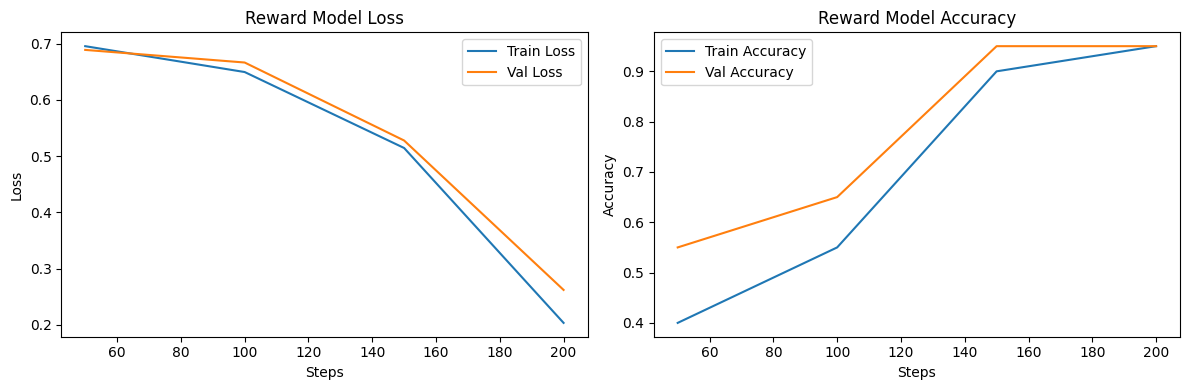

In [71]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
axes[0].plot(rm_tracking["steps"], rm_tracking["train_losses"], label="Train Loss")
axes[0].plot(rm_tracking["steps"], rm_tracking["val_losses"], label="Val Loss")
axes[0].set_xlabel("Steps")
axes[0].set_ylabel("Loss")
axes[0].set_title("Reward Model Loss")
axes[0].legend()

# Accuracy plot
axes[1].plot(rm_tracking["steps"], rm_tracking["train_accuracies"], label="Train Accuracy")
axes[1].plot(rm_tracking["steps"], rm_tracking["val_accuracies"], label="Val Accuracy")
axes[1].set_xlabel("Steps")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Reward Model Accuracy")
axes[1].legend()

plt.tight_layout()
plt.savefig("reward-model-training.pdf")
plt.show()


- Test the reward model on some examples:


In [72]:
# Test on some examples
reward_model.eval()

for i, entry in enumerate(val_data[:3]):
    prompt = format_input(entry)
    chosen_text = f"{prompt}\n\n### Response:\n{entry['chosen']}"
    rejected_text = f"{prompt}\n\n### Response:\n{entry['rejected']}"
    
    chosen_tokens = torch.tensor(tokenizer.encode(chosen_text)).unsqueeze(0).to(device)
    rejected_tokens = torch.tensor(tokenizer.encode(rejected_text)).unsqueeze(0).to(device)
    
    with torch.no_grad():
        chosen_reward = reward_model(chosen_tokens).item()
        rejected_reward = reward_model(rejected_tokens).item()
    
    print(f"Example {i+1}:")
    print(f"  Chosen response: '{entry['chosen'][:50]}...'")
    print(f"  Rejected response: '{entry['rejected'][:50]}...'")
    print(f"  Chosen reward: {chosen_reward:.4f}")
    print(f"  Rejected reward: {rejected_reward:.4f}")
    print(f"  Correct ranking: {chosen_reward > rejected_reward}")
    print()


Example 1:
  Chosen response: 'The meal is kindly prepared by the chef every day....'
  Rejected response: 'The meal is cooked by the chef every day....'
  Chosen reward: 7.3193
  Rejected reward: 4.9252
  Correct ranking: True

Example 2:
  Chosen response: ''Dance' may be classified as a verb....'
  Rejected response: ''Dance' can be classified as a verb....'
  Chosen reward: 6.4426
  Rejected reward: 6.1710
  Correct ranking: True

Example 3:
  Chosen response: 'The book is a page-turner....'
  Rejected response: 'The book is a freaking page-turner....'
  Chosen reward: 2.1398
  Rejected reward: -2.0558
  Correct ranking: True



&nbsp;
# 5) Step 2: PPO Training


- Now we implement PPO to optimize the policy model using the trained reward model
- PPO works by:
  1. Generating responses from the current policy
  2. Computing rewards using the reward model
  3. Computing advantages (how much better/worse than expected)
  4. Updating the policy with clipped objective to prevent too large updates
  5. Adding KL penalty to prevent deviation from the reference model


## 5.1) Setting Up Policy and Reference Models


In [73]:
# Policy model - the model we'll optimize
policy_model = GPTModel(BASE_CONFIG)
policy_model.load_state_dict(
    torch.load(
        "gpt2-medium355M-sft.pth",
        map_location=torch.device("cpu"),
        weights_only=True
    )
)
policy_model.to(device)
policy_model.train()

# Reference model - frozen, used for KL penalty
reference_model = GPTModel(BASE_CONFIG)
reference_model.load_state_dict(
    torch.load(
        "gpt2-medium355M-sft.pth",
        map_location=torch.device("cpu"),
        weights_only=True
    )
)
reference_model.to(device)
reference_model.eval()

# Freeze reference model
for param in reference_model.parameters():
    param.requires_grad = False

print("Policy and reference models loaded")


Policy and reference models loaded


## 5.2) Response Generation for PPO


In [ ]:
def generate_single_response(
    model,
    prompt_ids,
    max_new_tokens=64,
    temperature=1.0,
    eos_id=50256,
    min_new_tokens=5
):
    """
    Generate a response for a single prompt (no batching for reliability).
    
    Args:
        model: The language model
        prompt_ids: (1, prompt_len) tensor of prompt token IDs (single sample)
        max_new_tokens: Maximum tokens to generate
        temperature: Sampling temperature
        eos_id: End of sequence token ID
        min_new_tokens: Minimum tokens to generate before allowing EOS
        
    Returns:
        generated_ids: (1, prompt_len + gen_len) full sequence
        response_ids: (1, gen_len) just the generated part
        log_probs: (1, gen_len) log probabilities of generated tokens
        response_mask: (1, gen_len) mask for valid tokens
    """
    prompt_len = prompt_ids.shape[1]
    device = prompt_ids.device
    
    generated_ids = prompt_ids.clone()
    all_log_probs = []
    all_masks = []
    finished = False
    
    model.eval()
    
    for step in range(max_new_tokens):
        with torch.no_grad():
            logits = model(generated_ids)
            
        next_token_logits = logits[:, -1, :] / temperature
        
        # If we haven't generated min_new_tokens yet, prevent EOS
        if step < min_new_tokens:
            next_token_logits[:, eos_id] = float('-inf')
        
        probs = F.softmax(next_token_logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        
        log_probs = F.log_softmax(next_token_logits, dim=-1)
        selected_log_prob = torch.gather(log_probs, dim=-1, index=next_token)
        
        # Record before checking EOS
        all_log_probs.append(selected_log_prob.squeeze(-1))
        all_masks.append(torch.tensor([1.0 if not finished else 0.0], device=device))
        
        # Check for EOS
        if next_token.item() == eos_id:
            finished = True
        
        if finished:
            # Pad remaining positions with zeros
            next_token = torch.full_like(next_token, eos_id)
            
        generated_ids = torch.cat([generated_ids, next_token], dim=1)
        
        if finished:
            break
    
    # Stack and create tensors
    log_probs_tensor = torch.stack(all_log_probs, dim=1)
    response_mask = torch.stack(all_masks, dim=1)
    response_ids = generated_ids[:, prompt_len:]
    
    model.train()
    
    return generated_ids, response_ids, log_probs_tensor, response_mask


def generate_batch_responses(
    model,
    batch_prompts,
    prompt_lengths,
    max_new_tokens=64,
    temperature=1.0,
    eos_id=50256,
    pad_id=50256,
    min_new_tokens=5
):
    """
    Generate responses for a batch by processing each prompt individually.
    This is slower but more reliable than batched generation.
    
    Args:
        model: The language model
        batch_prompts: (batch_size, max_prompt_len) right-padded prompt tensor
        prompt_lengths: (batch_size,) actual lengths of each prompt
        max_new_tokens: Maximum tokens to generate
        temperature: Sampling temperature
        eos_id: End of sequence token ID
        pad_id: Padding token ID
        min_new_tokens: Minimum tokens before allowing EOS
        
    Returns:
        generated_ids: (batch_size, max_len) padded generated sequences
        response_ids: (batch_size, max_response_len) padded response sequences
        log_probs: (batch_size, max_response_len) log probs (padded with 0)
        response_mask: (batch_size, max_response_len) mask for valid tokens
    """
    batch_size = batch_prompts.shape[0]
    device = batch_prompts.device
    
    all_generated = []
    all_responses = []
    all_log_probs = []
    all_masks = []
    
    for i in range(batch_size):
        # Get the actual prompt (without right-padding)
        prompt_len = prompt_lengths[i].item()
        prompt = batch_prompts[i, :prompt_len].unsqueeze(0)
        
        gen_ids, resp_ids, lp, mask = generate_single_response(
            model, prompt, max_new_tokens, temperature, eos_id, min_new_tokens
        )
        
        all_generated.append(gen_ids.squeeze(0))
        all_responses.append(resp_ids.squeeze(0))
        all_log_probs.append(lp.squeeze(0))
        all_masks.append(mask.squeeze(0))
    
    # Pad to same length
    max_gen_len = max(g.shape[0] for g in all_generated)
    max_resp_len = max(r.shape[0] for r in all_responses)
    
    padded_generated = []
    padded_responses = []
    padded_log_probs = []
    padded_masks = []
    
    for gen, resp, lp, mask in zip(all_generated, all_responses, all_log_probs, all_masks):
        # Pad generated
        gen_pad = max_gen_len - gen.shape[0]
        padded_gen = F.pad(gen, (0, gen_pad), value=pad_id)
        padded_generated.append(padded_gen)
        
        # Pad response
        resp_pad = max_resp_len - resp.shape[0]
        padded_resp = F.pad(resp, (0, resp_pad), value=pad_id)
        padded_responses.append(padded_resp)
        
        # Pad log probs with 0
        padded_lp = F.pad(lp, (0, resp_pad), value=0.0)
        padded_log_probs.append(padded_lp)
        
        # Pad mask with 0
        padded_mask = F.pad(mask, (0, resp_pad), value=0.0)
        padded_masks.append(padded_mask)
    
    return (
        torch.stack(padded_generated),
        torch.stack(padded_responses),
        torch.stack(padded_log_probs),
        torch.stack(padded_masks)
    )


- Test the generation function:


In [ ]:
# Test generation
torch.manual_seed(123)

for batch in ppo_train_loader:
    break

generated_ids, response_ids, log_probs, response_mask = generate_batch_responses(
    policy_model,
    batch["prompt"],
    batch["prompt_lengths"],
    max_new_tokens=32,
    temperature=1.0,
    min_new_tokens=5
)

print("Generated IDs shape:", generated_ids.shape)
print("Response IDs shape:", response_ids.shape)
print("Log probs shape:", log_probs.shape)
print("Response mask shape:", response_mask.shape)
print("Valid tokens per sample:", response_mask.sum(dim=-1))
print("\nSample generated response:")
print(tokenizer.decode(generated_ids[0].tolist()))


Generated IDs shape: torch.Size([4, 71])
Response IDs shape: torch.Size([4, 21])
Log probs shape: torch.Size([4, 21])
Response mask shape: torch.Size([4, 21])

Sample generated response:
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the following sentence so that it is in active voice.

### Input:
The cake was baked by Sarah.

### Response:
Sarah baked the cake.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>


## 5.3) PPO Loss Functions


In [ ]:
def compute_log_probs_for_tokens(model, input_ids, target_ids, mask=None, prompt_lengths=None, average=True):
    """
    Compute log probabilities for specific target tokens.
    
    Args:
        model: Language model
        input_ids: (batch_size, seq_len) full sequences (prompt + response + padding)
        target_ids: (batch_size, target_len) target token IDs (response + padding)
        mask: (batch_size, target_len) mask for valid positions in target
        prompt_lengths: (batch_size,) length of each prompt, or None if all same
        average: If True, return average log prob per token; if False, return sum
        
    Returns:
        log_probs: (batch_size,) average or summed log probabilities per sequence
    """
    batch_size = input_ids.shape[0]
    target_len = target_ids.shape[1]
    device = input_ids.device
    
    # Get full logits
    logits = model(input_ids)  # (batch, seq_len, vocab)
    log_probs_full = F.log_softmax(logits, dim=-1)
    
    # For each sample, extract log probs for the response tokens
    all_selected_log_probs = []
    
    for i in range(batch_size):
        if prompt_lengths is not None:
            p_len = prompt_lengths[i].item()
        else:
            # Assume uniform prompt length
            p_len = input_ids.shape[1] - target_ids.shape[1]
        
        # Get logits at positions [p_len-1, p_len, ..., p_len+target_len-2]
        # These predict tokens at positions [p_len, p_len+1, ..., p_len+target_len-1]
        start_idx = p_len - 1
        end_idx = p_len - 1 + target_len
        
        # Make sure we don't go out of bounds
        end_idx = min(end_idx, log_probs_full.shape[1])
        actual_len = end_idx - start_idx
        
        if actual_len < target_len:
            # Pad with zeros if needed
            sample_log_probs = log_probs_full[i, start_idx:end_idx, :]
            # Gather log probs for target tokens
            sample_targets = target_ids[i, :actual_len]
            selected = torch.gather(sample_log_probs, dim=-1, index=sample_targets.unsqueeze(-1)).squeeze(-1)
            # Pad to target_len
            padding = torch.zeros(target_len - actual_len, device=device)
            selected = torch.cat([selected, padding])
        else:
            sample_log_probs = log_probs_full[i, start_idx:end_idx, :]
            selected = torch.gather(sample_log_probs, dim=-1, index=target_ids[i].unsqueeze(-1)).squeeze(-1)
        
        all_selected_log_probs.append(selected)
    
    selected_log_probs = torch.stack(all_selected_log_probs)  # (batch, target_len)
    
    # Apply mask if provided
    if mask is not None:
        selected_log_probs = selected_log_probs * mask
        seq_log_probs_sum = selected_log_probs.sum(dim=-1)
        if average:
            num_tokens = mask.sum(dim=-1).clamp(min=1)
            seq_log_probs = seq_log_probs_sum / num_tokens
        else:
            seq_log_probs = seq_log_probs_sum
    else:
        if average:
            seq_log_probs = selected_log_probs.mean(dim=-1)
        else:
            seq_log_probs = selected_log_probs.sum(dim=-1)
    
    return seq_log_probs


In [77]:
def compute_ppo_loss(
    policy_model,
    reference_model,
    generated_ids,
    response_ids,
    old_log_probs,
    rewards,
    response_mask,
    clip_epsilon=0.2,
    kl_coef=0.1
):
    """
    Compute the PPO loss with clipping and KL penalty.
    
    Args:
        policy_model: Current policy model
        reference_model: Frozen reference model
        generated_ids: (batch_size, total_len) full generated sequences
        response_ids: (batch_size, response_len) just the response part
        old_log_probs: (batch_size,) log probs from the old policy
        rewards: (batch_size,) rewards from reward model
        response_mask: (batch_size, response_len) mask for valid tokens
        clip_epsilon: PPO clipping parameter
        kl_coef: Coefficient for KL penalty
        
    Returns:
        loss: Total PPO loss
        stats: Dictionary with additional statistics
    """
    # Compute new log probabilities under current policy
    new_log_probs = compute_log_probs_for_tokens(
        policy_model, generated_ids, response_ids, response_mask
    )
    
    # Compute log probabilities under reference model (for KL penalty)
    with torch.no_grad():
        ref_log_probs = compute_log_probs_for_tokens(
            reference_model, generated_ids, response_ids, response_mask
        )
    
    # Compute advantages (simple version: just use rewards as advantages)
    # In a more sophisticated implementation, you'd use GAE
    advantages = rewards - rewards.mean()
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
    
    # PPO ratio
    ratio = torch.exp(new_log_probs - old_log_probs)
    
    # Clipped objective
    clipped_ratio = torch.clamp(ratio, 1 - clip_epsilon, 1 + clip_epsilon)
    policy_loss = -torch.min(ratio * advantages, clipped_ratio * advantages).mean()
    
    # KL penalty (per-token average)
    # KL(policy || ref) = sum(policy * log(policy/ref)) 
    # Approximated as: policy_log_prob - ref_log_prob
    kl_div = (new_log_probs - ref_log_probs).mean()
    kl_penalty = kl_coef * kl_div
    
    # Total loss
    total_loss = policy_loss + kl_penalty
    
    # Collect statistics
    stats = {
        "policy_loss": policy_loss.item(),
        "kl_div": kl_div.item(),
        "kl_penalty": kl_penalty.item(),
        "mean_ratio": ratio.mean().item(),
        "mean_advantage": advantages.mean().item(),
        "mean_reward": rewards.mean().item(),
    }
    
    return total_loss, stats


## 5.4) PPO Training Loop


In [ ]:
def train_ppo(
    policy_model,
    reference_model,
    reward_model,
    train_loader,
    optimizer,
    tokenizer,
    num_epochs=1,
    ppo_epochs=4,  # Number of PPO updates per batch
    max_new_tokens=64,
    temperature=1.0,
    clip_epsilon=0.2,
    kl_coef=0.1,
    max_kl=0.5,  # Stop PPO epochs if KL exceeds this
    eval_freq=10,
    max_batches=None
):
    """
    Train the policy model using PPO.
    
    Args:
        policy_model: Model to train
        reference_model: Frozen reference for KL penalty
        reward_model: Trained reward model
        train_loader: DataLoader with prompts
        optimizer: Optimizer for policy model
        tokenizer: Tokenizer for decoding
        num_epochs: Number of training epochs over the dataset
        ppo_epochs: Number of PPO gradient updates per batch of generated data
        max_new_tokens: Max tokens to generate per response
        temperature: Sampling temperature
        clip_epsilon: PPO clipping parameter
        kl_coef: KL penalty coefficient
        max_kl: Maximum KL before stopping PPO epochs early
        eval_freq: How often to print stats
        max_batches: Maximum batches per epoch (for debugging)
        
    Returns:
        tracking: Dictionary with training statistics
    """
    tracking = {
        "policy_losses": [],
        "kl_divs": [],
        "mean_rewards": [],
        "steps": []
    }
    
    global_step = 0
    
    for epoch in range(num_epochs):
        policy_model.train()
        reward_model.eval()
        
        for batch_idx, batch in enumerate(train_loader):
            if max_batches is not None and batch_idx >= max_batches:
                break
            
            # Step 1: Generate responses from current policy (no grad)
            policy_model.eval()
            with torch.no_grad():
                generated_ids, response_ids, old_log_probs_per_token, response_mask = \
                    generate_batch_responses(
                        policy_model,
                        batch["prompt"],
                        batch["prompt_lengths"],
                        max_new_tokens=max_new_tokens,
                        temperature=temperature,
                        min_new_tokens=5  # Force at least 5 tokens before EOS
                    )
                
                # Average log probs over valid tokens (more stable than sum)
                num_valid_tokens = response_mask.sum(dim=-1).clamp(min=1)
                old_log_probs = (old_log_probs_per_token * response_mask).sum(dim=-1) / num_valid_tokens
                
                # Step 2: Compute rewards using reward model
                rewards = reward_model(generated_ids)
                
                # Compute reference log probs once (won't change)
                ref_log_probs = compute_log_probs_for_tokens(
                    reference_model, generated_ids, response_ids, response_mask,
                    prompt_lengths=batch["prompt_lengths"], average=True
                )
            
            # Skip batch if rewards have no variance (can't normalize)
            if rewards.std() < 1e-6:
                continue
                
            # Normalize rewards for stability
            rewards_normalized = (rewards - rewards.mean()) / (rewards.std() + 1e-8)
            
            # Step 3: Multiple PPO epochs on the same batch
            policy_model.train()
            for ppo_epoch in range(ppo_epochs):
                optimizer.zero_grad()
                
                # Compute NEW log probabilities under CURRENT policy
                new_log_probs = compute_log_probs_for_tokens(
                    policy_model, generated_ids, response_ids, response_mask,
                    prompt_lengths=batch["prompt_lengths"], average=True
                )
                
                # PPO ratio: exp(new - old)
                # Clamp the difference to prevent extreme ratios
                log_ratio = (new_log_probs - old_log_probs).clamp(-10, 10)
                ratio = torch.exp(log_ratio)
                
                # Use normalized rewards as advantages
                advantages = rewards_normalized
                
                # Clipped objective
                clipped_ratio = torch.clamp(ratio, 1 - clip_epsilon, 1 + clip_epsilon)
                policy_loss = -torch.min(
                    ratio * advantages, 
                    clipped_ratio * advantages
                ).mean()
                
                # KL penalty against reference model (use absolute value)
                kl_div = (new_log_probs - ref_log_probs).mean()
                kl_penalty = kl_coef * torch.abs(kl_div)
                
                # Total loss
                loss = policy_loss + kl_penalty
                
                # Check for NaN/inf
                if torch.isnan(loss) or torch.isinf(loss):
                    print(f"Warning: NaN/Inf loss detected at step {global_step}, skipping batch")
                    break
                
                loss.backward()
                
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(policy_model.parameters(), max_norm=0.5)
                
                optimizer.step()
                
                # Early stopping if KL is too high
                if torch.abs(kl_div) > max_kl:
                    break
            
            global_step += 1
            
            # Track statistics (after all PPO epochs)
            with torch.no_grad():
                final_log_probs = compute_log_probs_for_tokens(
                    policy_model, generated_ids, response_ids, response_mask,
                    prompt_lengths=batch["prompt_lengths"], average=True
                )
                final_ratio = torch.exp((final_log_probs - old_log_probs).clamp(-10, 10))
                final_kl = (final_log_probs - ref_log_probs).mean()
            
            stats = {
                "policy_loss": policy_loss.item(),
                "kl_div": final_kl.item(),
                "mean_ratio": final_ratio.mean().item(),
                "mean_reward": rewards.mean().item(),
            }
            
            tracking["policy_losses"].append(stats["policy_loss"])
            tracking["kl_divs"].append(stats["kl_div"])
            tracking["mean_rewards"].append(stats["mean_reward"])
            tracking["steps"].append(global_step)
            
            # Print progress
            if global_step % eval_freq == 0:
                print(
                    f"Epoch {epoch+1} Step {global_step}: "
                    f"Loss={loss.item():.4f}, "
                    f"Policy Loss={stats['policy_loss']:.4f}, "
                    f"KL={stats['kl_div']:.4f}, "
                    f"Ratio={stats['mean_ratio']:.4f}, "
                    f"Reward={stats['mean_reward']:.4f}"
                )
                
                # Print a sample response
                sample_response = tokenizer.decode(generated_ids[0].tolist())
                response_start = sample_response.find("### Response:")
                if response_start != -1:
                    sample_response = sample_response[response_start:]
                print(f"  Sample: {sample_response[:100]}...")
                print()
    
    return tracking


In [ ]:
torch.manual_seed(123)

# Reload policy model to start fresh
policy_model = GPTModel(BASE_CONFIG)
policy_model.load_state_dict(
    torch.load(
        "gpt2-medium355M-sft.pth",
        map_location=torch.device("cpu"),
        weights_only=True
    )
)
policy_model.to(device)
policy_model.train()

# Use a conservative learning rate
ppo_optimizer = torch.optim.AdamW(
    policy_model.parameters(), 
    lr=5e-6,  # Conservative learning rate
    weight_decay=0.01
)

start_time = time.time()

ppo_tracking = train_ppo(
    policy_model=policy_model,
    reference_model=reference_model,
    reward_model=reward_model,
    train_loader=ppo_train_loader,
    optimizer=ppo_optimizer,
    tokenizer=tokenizer,
    num_epochs=1,
    ppo_epochs=2,  # Fewer PPO epochs to prevent over-updating
    max_new_tokens=48,
    temperature=0.8,  # Slightly lower temperature for more focused sampling
    clip_epsilon=0.1,  # Tighter clipping for more conservative updates
    kl_coef=0.1,  # KL penalty to stay close to reference
    max_kl=0.3,  # Stop early if KL gets too high
    eval_freq=10,
    max_batches=100
)

end_time = time.time()
print(f"\nPPO training completed in {(end_time - start_time) / 60:.2f} minutes")


Epoch 1 Step 10: Loss=11.8606, Policy Loss=-0.0519, KL=229.3354, Ratio=0.9491, Reward=-0.3280
  Sample: <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endofte...

Epoch 1 Step 20: Loss=0.3638, Policy Loss=0.0444, KL=5.9206, Ratio=0.5361, Reward=3.1449
  Sample: Below is an instruction that describes a task. Write a response that appropriately completes the req...

Epoch 1 Step 30: Loss=0.0000, Policy Loss=0.0000, KL=0.0000, Ratio=1.0000, Reward=3.3647
  Sample: <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>Below is ...

Epoch 1 Step 40: Loss=0.0000, Policy Loss=0.0000, KL=0.0000, Ratio=1.0000, Reward=2.9025
  Sample: <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endofte...

Epoch 1 Step 50: Loss=-0.0000, Policy Loss=-0.0000, KL=0.0000, Ratio=1.0000, Reward=2.7967
  Sample: <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>

## 5.5) Plotting PPO Training Metrics


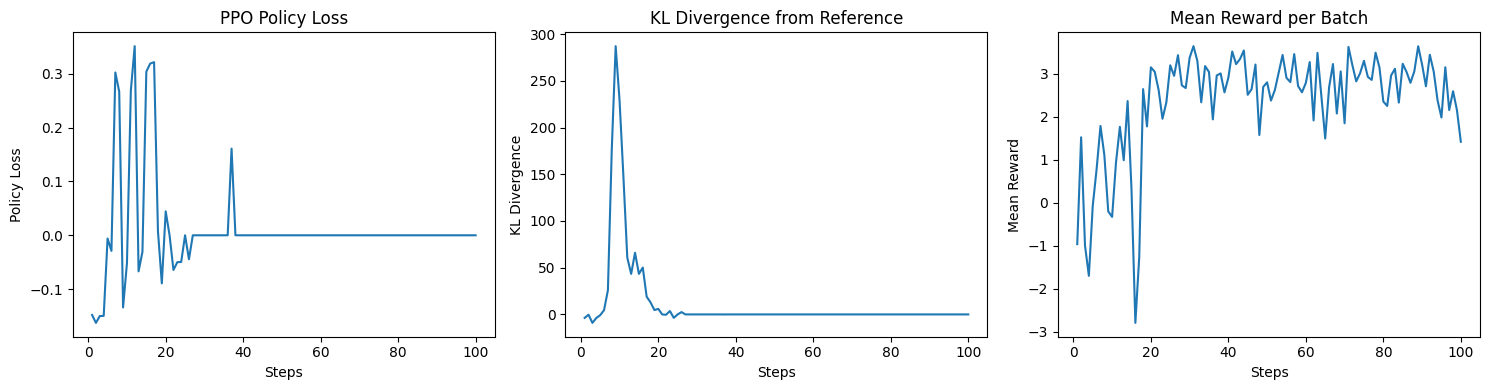

In [80]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Policy loss
axes[0].plot(ppo_tracking["steps"], ppo_tracking["policy_losses"])
axes[0].set_xlabel("Steps")
axes[0].set_ylabel("Policy Loss")
axes[0].set_title("PPO Policy Loss")

# KL divergence
axes[1].plot(ppo_tracking["steps"], ppo_tracking["kl_divs"])
axes[1].set_xlabel("Steps")
axes[1].set_ylabel("KL Divergence")
axes[1].set_title("KL Divergence from Reference")

# Mean rewards
axes[2].plot(ppo_tracking["steps"], ppo_tracking["mean_rewards"])
axes[2].set_xlabel("Steps")
axes[2].set_ylabel("Mean Reward")
axes[2].set_title("Mean Reward per Batch")

plt.tight_layout()
plt.savefig("ppo-training.pdf")
plt.show()


&nbsp;
# 6) Analyzing the Results


- Let's compare the responses from the reference model (before PPO) and the policy model (after PPO)
- We'll also compute rewards for both to see if PPO training improved the model


## 6.1) Comparing Model Responses


In [81]:
def generate_response(model, prompt_text, tokenizer, device, max_new_tokens=100):
    """Generate a response from a model given a text prompt."""
    model.eval()
    
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(prompt_text, tokenizer).to(device),
        max_new_tokens=max_new_tokens,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(prompt_text):].replace("### Response:", "").strip()
    
    return response_text, token_ids


In [82]:
torch.manual_seed(123)

print("=" * 80)
print("COMPARING REFERENCE MODEL VS PPO-TRAINED POLICY MODEL")
print("=" * 80)

for i, entry in enumerate(val_data[:5]):
    input_text = format_input(entry)
    
    # Generate from reference model
    ref_response, ref_tokens = generate_response(
        reference_model, input_text, tokenizer, device, max_new_tokens=100
    )
    
    # Generate from policy model
    policy_response, policy_tokens = generate_response(
        policy_model, input_text, tokenizer, device, max_new_tokens=100
    )
    
    # Compute rewards
    with torch.no_grad():
        ref_reward = reward_model(ref_tokens.to(device)).item()
        policy_reward = reward_model(policy_tokens.to(device)).item()
    
    print(f"\n{'='*80}")
    print(f"Example {i+1}")
    print(f"{'='*80}")
    print(f"\nPrompt:\n{entry['instruction'][:100]}...")
    print(f"\nExpected (chosen) response:\n>> {entry['chosen']}")
    print(f"\nReference model response (Reward: {ref_reward:.4f}):\n>> {ref_response}")
    print(f"\nPolicy model response (Reward: {policy_reward:.4f}):\n>> {policy_response}")
    print(f"\nReward improvement: {policy_reward - ref_reward:+.4f}")


COMPARING REFERENCE MODEL VS PPO-TRAINED POLICY MODEL

Example 1

Prompt:
Convert the active sentence to passive: 'The chef cooks the meal every day.'...

Expected (chosen) response:
>> The meal is kindly prepared by the chef every day.

Reference model response (Reward: 5.2930):
>> The meal is cooked every day by the chef.

Policy model response (Reward: 4.3524):
>> 

Reward improvement: -0.9407

Example 2

Prompt:
Classify an input string as either a noun or a verb....

Expected (chosen) response:
>> 'Dance' may be classified as a verb.

Reference model response (Reward: 5.5336):
>> Dance is a verb.

Policy model response (Reward: 2.7382):
>> 

Reward improvement: -2.7953

Example 3

Prompt:
Rewrite the sentence using a metaphor....

Expected (chosen) response:
>> The book is a page-turner.

Reference model response (Reward: -1.2418):
>> The book is like a novel.

Policy model response (Reward: 3.6930):
>> 

Reward improvement: +4.9348

Example 4

Prompt:
Generate a question with the

## 6.2) Quantitative Evaluation on Test Set


In [83]:
def evaluate_model_rewards(model, reward_model, data, tokenizer, device, num_samples=20):
    """Evaluate a model by computing mean reward on generated responses."""
    model.eval()
    reward_model.eval()
    
    rewards = []
    
    for entry in data[:num_samples]:
        input_text = format_input(entry)
        _, token_ids = generate_response(model, input_text, tokenizer, device, max_new_tokens=80)
        
        with torch.no_grad():
            reward = reward_model(token_ids.to(device)).item()
        rewards.append(reward)
    
    return np.mean(rewards), np.std(rewards)

import numpy as np

torch.manual_seed(123)

# Evaluate reference model
ref_mean, ref_std = evaluate_model_rewards(
    reference_model, reward_model, test_data, tokenizer, device, num_samples=20
)
print(f"Reference Model - Mean Reward: {ref_mean:.4f} (+/- {ref_std:.4f})")

# Evaluate policy model
policy_mean, policy_std = evaluate_model_rewards(
    policy_model, reward_model, test_data, tokenizer, device, num_samples=20
)
print(f"Policy Model - Mean Reward: {policy_mean:.4f} (+/- {policy_std:.4f})")

print(f"\nImprovement: {policy_mean - ref_mean:+.4f}")


Reference Model - Mean Reward: 4.9202 (+/- 1.2049)
Policy Model - Mean Reward: 3.5131 (+/- 1.0546)

Improvement: -1.4072


## 6.3) Summary


In this notebook, we implemented the full RLHF pipeline with PPO from scratch:

**Step 1: Reward Model Training**
- Built a reward model by adding a value head to the GPT architecture
- Trained it on preference data (chosen vs rejected responses)
- The reward model learns to assign higher scores to preferred responses

**Step 2: PPO Training**
- Generated responses from the policy model
- Computed rewards using the trained reward model
- Updated the policy using the PPO objective with:
  - Clipped policy ratio to prevent large updates
  - KL penalty to stay close to the reference model

**Key Observations:**
- PPO requires careful tuning of hyperparameters (learning rate, KL coefficient, clip epsilon)
- Training can be unstable - monitor rewards and KL divergence
- The reward model quality is crucial for successful PPO training

**Comparison with DPO:**
- PPO is more flexible but more complex to implement
- DPO directly optimizes preferences without a separate reward model
- Both methods aim to align LLMs with human preferences


## 6.4) Optional: Save the Trained Models


In [84]:
# Save the reward model
torch.save(reward_model.state_dict(), "reward-model.pth")
print("Reward model saved to reward-model.pth")

# Save the PPO-trained policy model
torch.save(policy_model.state_dict(), "gpt2-medium355M-ppo.pth")
print("PPO-trained policy model saved to gpt2-medium355M-ppo.pth")


Reward model saved to reward-model.pth
PPO-trained policy model saved to gpt2-medium355M-ppo.pth
